In [36]:
import pandas as pd
import numpy as np
import xgboost as xgb
# from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import optuna
import seaborn as sns
import os
import copy
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [37]:
# Save the train and test DataFrames

PREPROCESS_DIR = "processed_data/glcm/"
X_TRAIN_DIR = PREPROCESS_DIR + "X_train.pkl"
y_TRAIN_DIR = PREPROCESS_DIR + "y_train.pkl"
X_TEST_DIR = PREPROCESS_DIR + "X_test.pkl"
y_TEST_DIR = PREPROCESS_DIR + "y_test.pkl"

X_train = pd.read_pickle(X_TRAIN_DIR)
y_train = pd.read_pickle(y_TRAIN_DIR)
X_test = pd.read_pickle(X_TEST_DIR)
y_test = pd.read_pickle(y_TEST_DIR)


## If feature selection
# FEATURE_SELECTION = "processed_data/ft/"
# FT_FILE = "xgb_ft_d5_a4.pkl"

# import joblib

# CURRENT_DIRECTORY = os.getcwd()
# FEATURE_SORTED = joblib.load(FEATURE_SELECTION + FT_FILE)
# NUM_FEAT = 30
# FEATURES = FEATURE_SORTED[:NUM_FEAT]
# print(FEATURES)

# X_train = X_train[FEATURES]
# X_test = X_test[FEATURES]

print("Old")
print(X_test.shape)
print(X_train.shape)

Old
(1030, 67)
(4129, 67)


## SMOTE 

In [38]:
# print('Original dataset shape %s' % Counter(y_train))

# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# print('Resampled dataset shape %s' % Counter(y_train))

In [39]:
data = {'X_train': X_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_train': y_train}

## Modelling
Models available: Plain_rf, Rf_op, Plain_xgb, xgb_op

In [40]:
def evaluate(y_test, y_pred):
    results = {
        'recall': recall_score(y_test, y_pred, average = 'weighted'),
        'precision': precision_score(y_test, y_pred, average = 'weighted'),
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred, average = 'weighted')
    }
    return results

def plain_rf(X_train, y_train, X_test, y_test, metric = "recall"):
    
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)

    pred = rf_model.predict(X_test)

    results = evaluate(y_test, pred)

    print(classification_report(y_test, pred))

    plot_cl(y_test, pred)

    return pred, results[metric]

def rf_op(X_train, y_train, X_test, y_test, metric = "recall"):

    def rf_trial(trial, final = False):
        param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt']),
        # 'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
        }

        model = RandomForestClassifier(**param)
        model.fit(X_train, y_train)

        preds = model.predict(X_test)
        result = evaluate(y_test, preds)

        if final:
            print(classification_report(y_test, preds))
            plot_cl(y_test, preds)

            return preds, result[metric]
        

    study = optuna.create_study(direction = "maximize")
    study.optimize(rf_trial, n_trials = 10)

    model = study.best_trial
    model_copy = copy.deepcopy(model)

    pred, results = rf_trial(model_copy, final = True)

    return pred, results

def plain_xgb(X_train, y_train, X_test, y_test, metric = "recall"):
    """
    Perform XGBoost multiclass classification, evaluate the model, and create a confusion matrix.

    Parameters:
    X_train (torch.Tensor): Training features.
    y_train (torch.Tensor): Training labels.
    X_test (torch.Tensor): Testing features.
    y_test (torch.Tensor): Testing labels.

    Returns:
    None
    """
    
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    print(classification_report(y_test, pred))

    plot_cl(y_test, pred)

    results = evaluate(y_test, pred)

    return pred, results[metric]
    
    
def xgb_op(X_train, X_test, y_train, y_test, metric = 'accuracy'):
    

    def xgb_trial(trial, final = False):

        param = {
        'objective': 'multi:softmax',  # For multiclass classification
        'num_class': len(set(y_train)),  # Number of classes
        'eval_metric': 'mlogloss',  # Multiclass log loss
        'tree_method': 'hist',  # Faster training method
        'booster': 'gbtree',
        'verbosity': 0,
        'n_jobs': -1,
        'use_label_encoder': False,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-5, 1e3),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e1),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1),
        'n_estimators': 100
        }

        model = xgb.XGBClassifier(**param)

        model.fit(X_train, y_train)

        pred = model.predict(X_test)

        results = evaluate(y_test, pred)

        if final:
            print(classification_report(y_test, pred))
            plot_cl(y_test, pred)

            return pred, results[metric]

        return results[metric]

    study = optuna.create_study(direction = "maximize")
    study.optimize(xgb_trial, n_trials = 10)

    model = study.best_trial
    model_copy = copy.deepcopy(model)

    pred, results = xgb_trial(model_copy, final = True)

    return pred, results


def plot_cl(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels= set(y_test), yticklabels=set(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def roc_curve(y_test, y_pred):

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Calculate the Area Under the ROC Curve (AUC)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()



[I 2023-11-06 22:44:07,261] A new study created in memory with name: no-name-957ea8de-0d60-4c22-9816-083bfe7fdf61
[I 2023-11-06 22:44:09,034] Trial 0 finished with value: 0.7310679611650486 and parameters: {'max_depth': 6, 'min_child_weight': 1.8500655661442365, 'subsample': 0.6163502635385809, 'colsample_bytree': 0.510377491002106, 'reg_alpha': 0.02157935692930437, 'reg_lambda': 0.0007160442479341176, 'learning_rate': 0.07948029076840422}. Best is trial 0 with value: 0.7310679611650486.
[I 2023-11-06 22:44:12,649] Trial 1 finished with value: 0.6757281553398058 and parameters: {'max_depth': 6, 'min_child_weight': 0.0002472251340460917, 'subsample': 0.5674549424055743, 'colsample_bytree': 0.5422296013865693, 'reg_alpha': 9.719509272847837, 'reg_lambda': 0.03218282816537459, 'learning_rate': 0.07333828020545026}. Best is trial 0 with value: 0.7310679611650486.
[I 2023-11-06 22:44:15,714] Trial 2 finished with value: 0.5815533980582525 and parameters: {'max_depth': 5, 'min_child_weight':

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       511
           1       0.71      0.74      0.72       358
           2       0.77      0.55      0.64       151
           3       1.00      0.30      0.46        10

    accuracy                           0.77      1030
   macro avg       0.82      0.61      0.67      1030
weighted avg       0.77      0.77      0.77      1030



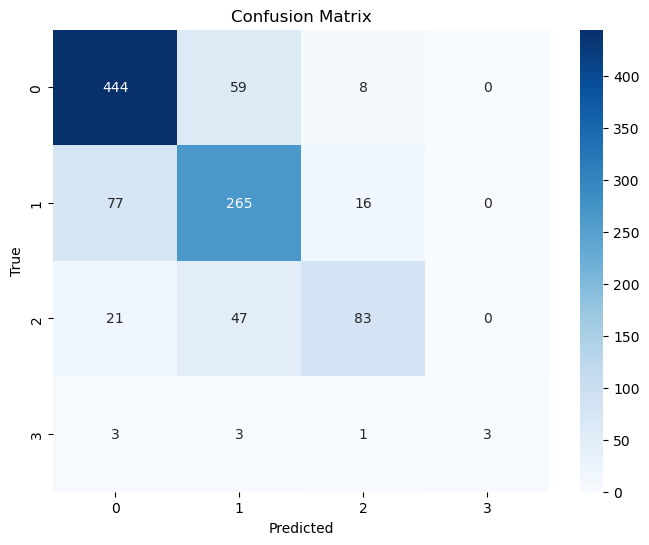

In [41]:
y_pred, results = xgb_op(**data)